#Bag of words

In [ ]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [ ]:
sample = ['من رفتم تهران', 'من در تهران زندگی میکنم', 'تهران زیبا است']

In [ ]:
vect.fit(sample)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:

vect.get_feature_names()

['است', 'تهران', 'در', 'رفتم', 'زندگی', 'زیبا', 'من', 'میکنم']

In [ ]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_train_dtm = vect.transform(sample)
simple_train_dtm

<3x8 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [ ]:
simple_train_dtm.toarray()

array([[0, 1, 0, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 1, 0, 1, 1],
       [1, 1, 0, 0, 0, 1, 0, 0]])

In [ ]:
# examine the vocabulary and document-term matrix together
import pandas as pd

pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,است,تهران,در,رفتم,زندگی,زیبا,من,میکنم
0,0,1,0,1,0,0,1,0
1,0,1,1,0,1,0,1,1
2,1,1,0,0,0,1,0,0


#TFIDF

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re

vect = TfidfVectorizer()
vect.fit(sample)
simple_train_dtm = vect.transform(sample)
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,است,تهران,در,رفتم,زندگی,زیبا,من,میکنم
0,0.000000,0.425441,0.000000,0.720333,0.000000,0.000000,0.547832,0.000000
1,0.000000,0.298032,0.504611,0.000000,0.504611,0.000000,0.383770,0.504611
2,0.652491,0.385372,0.000000,0.000000,0.000000,0.652491,0.000000,0.000000


#Word2vec

In [ ]:

import numpy as np


from gensim.models.phrases import Phrases, Phraser


In [ ]:
df = pd.read_csv('simpsons_dataset.csv')
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
df.shape

(158314, 2)

In [ ]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [ ]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

Cleaning

In [ ]:
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [ ]:
from  time import time
import re
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.04 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85964, 1)

In [ ]:
df_clean.head()

,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live
4,poll open end recess case decide thought final...
7,victory party slide


In [ ]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
sentences = phrases[sent]


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
from collections import defaultdict
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


30178

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:5]

['oh', 'like', 'know', 'get', 'hey']

In [ ]:


from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1)

In [ ]:


w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Time to build vocab: 1.17 mins


In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
w2v_model.wv.most_similar(positive=["homer"])

[('campaign', 0.19149626791477203),
 ('sweater', 0.1838568150997162),
 ('declare', 0.1829453408718109),
 ('responsibility', 0.182439923286438),
 ('yogurt', 0.1770438551902771),
 ('century', 0.1753128468990326),
 ('sector', 0.17387714982032776),
 ('lou', 0.17337660491466522),
 ('fourth', 0.17247435450553894),
 ('service', 0.1671232134103775)]

In [ ]:
w2v_model.wv.most_similar(positive=["marge"])

[('opera', 0.23657609522342682),
 ('big', 0.210626482963562),
 ('chef', 0.2011110484600067),
 ('roast', 0.20064318180084229),
 ('bum', 0.1937980353832245),
 ('prime', 0.18154343962669373),
 ('japan', 0.18016010522842407),
 ('golf', 0.17836618423461914),
 ('effort', 0.17650018632411957),
 ('proposition', 0.1667303442955017)]

In [ ]:
w2v_model.wv.most_similar(positive=["bart"])

[('sponsor', 0.2057056427001953),
 ('snowball', 0.18019697070121765),
 ('point', 0.1724226474761963),
 ('el', 0.1721421480178833),
 ('blind', 0.16930237412452698),
 ('eyeball', 0.16849848628044128),
 ('tunnel', 0.16637375950813293),
 ('technology', 0.1656838208436966),
 ('whee', 0.16248661279678345),
 ('tap', 0.1621415764093399)]

#Elmo

In [ ]:
!pip install tensorflow_hub==0.6
%tensorflow_version 1.5x

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.5x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
samples = ['i play tennis', ' we listen to conference', 'we are great']


elmo = hub.Module("https://tfhub.dev/google/elmo/2")
embeddings = elmo(
   samples,
    signature="default",
    as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
embeddings

<tf.Tensor 'module_apply_default/aggregation/mul_3:0' shape=(3, 4, 1024) dtype=float32>

#Glove

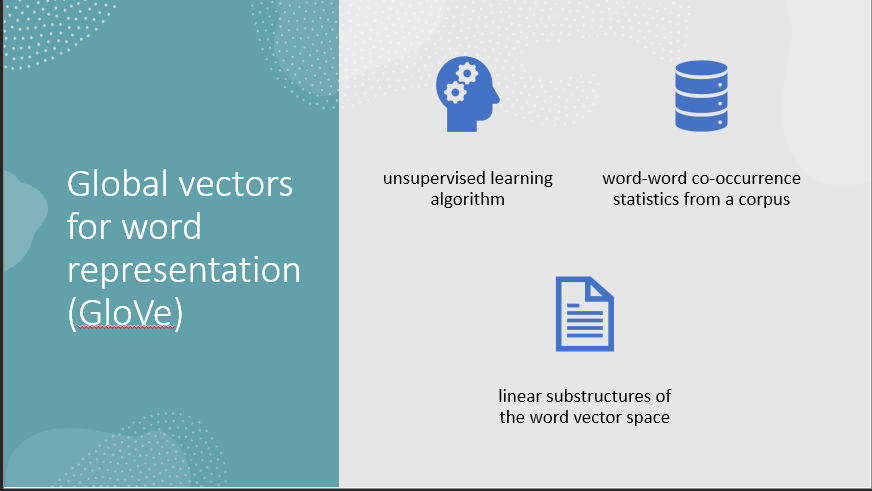

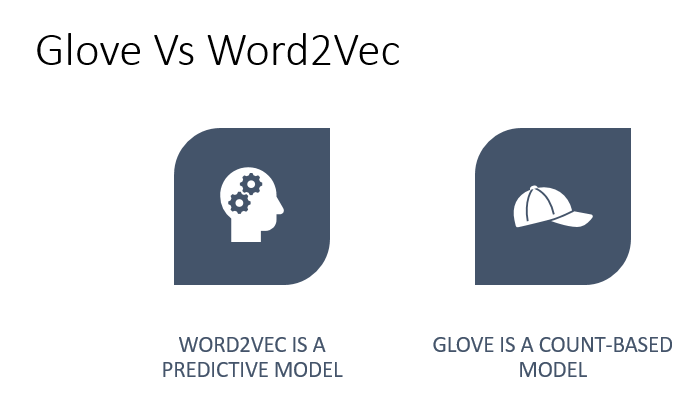

In [ ]:
!unzip glove.6B.100d.txt.zip

Archive:  glove.6B.100d.txt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
embeddings_dict = {}
with open("glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

In [ ]:
find_closest_embeddings(embeddings_dict["king"])[:5]

['king', 'prince', 'queen', 'monarch', 'brother']

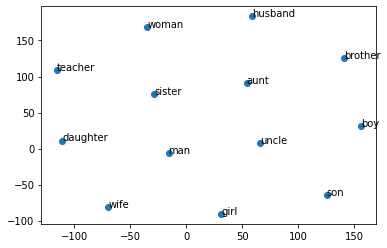

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
words = ['sister', 'brother', 'man', 'woman', 'uncle', 'aunt', 'teacher', 'boy', 'girl', 'son', 'daughter',
         'husband', 'wife']

vectors = [embeddings_dict[word] for word in words]
Y = tsne.fit_transform(vectors[:1000])
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

#links to lookup 
[glove](https://nlp.stanford.edu/projects/glove/)

[word2vec](https://radimrehurek.com/gensim/models/word2vec.html)

